# Can we improve an LSTM with `fit_residual`?

**TLDR;** Yes, with `fit_residual`, the LSTM matches the test MAE of the stacked GRU.

It's interesting that `fit_residual` doesn't help the stacked GRU - suggesting that the stacked GRU is able to learn this feature without any help?

# Can using the date feature help any of these models?

**TLDR;** Yes, this helps the fully connected model get pretty close to the test MAE of the stacked GRU.

This also helps the LSTM get a test MAE of 2.32 (11.5% improvement over the baseline and 2.9% improvement over the stacked GRU).

# Functions that make it easy to try different combinations of ideas;

## `data_to_np`

Convert `lines` to numpy arrays.

### `use_date_features`

Pass `use_date_features=True`, to include date features in the input data.

## `new_model`

Create a new fully connected model.

### `fit_residual`

Can a model learn to correct the errors of the common-sense, non-machine learning baseline?

Pass `fit_residual=True`, to add the temperature as it is "now" to the output of the last dense layer to get our final predictions.

### `temporal_weight_range`

Can we tell our model to pay more attention to data from the recent past?

e.g. `[0.0, 2.0]` reduces the magnitude of earlier observations and increases the magnitude of recent observations.

### `l2_factor`

See [regularizers.l2](https://keras.io/api/layers/regularizers/)

### `dropout_rate`

See [layers.Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

## `compile_and_fit`

Compile and fit `model` saving checkpoints to `f'jena_dense_{model_tag}.keras'`.

## `evaluate_model`

Calculates metrics for a model checkpoint saved as `f'jena_dense_{model_tag}.keras'` using the test dataset.

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from pathlib import Path
from functools import partial
try:
    from utils.plot_history import *
except ModuleNotFoundError:
    if not Path('plot_history.py').is_file():
        !wget https://raw.githubusercontent.com/pete88b/deep_learning_with_python/main/utils/plot_history.py
    from plot_history import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-y95s463e because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
Path('data/models').mkdir(exist_ok=True, parents=True)
if not Path('data/jena_climate_2009_2016.csv').is_file():
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip -d data
with open("data/jena_climate_2009_2016.csv") as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(len(header), 'features', len(lines), 'rows of data')
print(header)

15 features 420451 rows of data
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


# Add date features

## TODO: Make day of week categorical

Categorical day of week might make sense as things like polution from traffic can be different on the weekend.

Also use embedding like fastai tabular?

In [3]:
def create_date_features(date_str):
    d = datetime.strptime(date_str, '%d.%m.%Y %H:%M:%S')
    hour_of_day = d.hour # 0-23
    day_of_week = d.weekday() # Monday is 0 
    day_of_year = int(d.strftime('%j')) # 1-365
    sin_hour_of_day, cos_hour_of_day = [f(2 * np.pi * hour_of_day / 24) for f in [np.sin, np.cos]]
    sin_day_of_year, cos_day_of_year = [f(2 * np.pi * day_of_year / 365) for f in [np.sin, np.cos]]
    return [sin_hour_of_day, cos_hour_of_day, day_of_week, sin_day_of_year, cos_day_of_year]

In [4]:
for line in lines[0:30:6]:
    split_line = line.split(",")
    print(split_line[0], create_date_features(split_line[0]))

01.01.2009 00:10:00 [0.0, 1.0, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 01:10:00 [0.25881904510252074, 0.9659258262890683, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 02:10:00 [0.49999999999999994, 0.8660254037844387, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 03:10:00 [0.7071067811865475, 0.7071067811865476, 3, 0.017213356155834685, 0.9998518392091162]
01.01.2009 04:10:00 [0.8660254037844386, 0.5000000000000001, 3, 0.017213356155834685, 0.9998518392091162]


# Convert data to np and normalize

In [5]:
n_train_samples = 210225
n_val_samples = 105112
n_test_samples = 105114

In [6]:
def data_to_np(use_date_features=False):
    n_date_features = 5 if use_date_features else 0
    temperature = np.zeros((len(lines),))
    raw_data = np.zeros((len(lines), len(header) - 1 + n_date_features))
    for i, line in enumerate(lines):
        split_line = line.split(",")
        values = [float(x) for x in split_line[1:]] 
        if use_date_features:
            values = values + create_date_features(split_line[0])
        temperature[i] = values[1]
        raw_data[i, :] = values[:] # features inc. temp
    mean = raw_data[:n_train_samples].mean(axis=0)
    std = raw_data[:n_train_samples].std(axis=0)
    raw_data -= mean
    raw_data /= std
    return temperature, raw_data, mean, std

# Create datasets

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1024 # larger batch size makes training faster but might be changing effective learning rate
def new_dataset(start_index, end_index):
    dataset = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=temperature[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=start_index == 0, # only shuffle train
            batch_size=batch_size,
            start_index=start_index,
            end_index=end_index)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [8]:
def new_datasets():
    train_dataset = new_dataset(0, n_train_samples)
    val_dataset = new_dataset(n_train_samples, n_train_samples + n_val_samples)
    test_dataset = new_dataset(n_train_samples + n_val_samples, None)
    return train_dataset, val_dataset, test_dataset

# Functions to build and train models

In [9]:
def new_model(temporal_weight_range=None, l2_factor=None, dropout_rate=None, fit_residual=False):
    "Create a fully connected model"
    inputs = layers.Input(shape=(sequence_length, raw_data.shape[-1]))
    if temporal_weight_range is not None:
        temporal_weight_mask = tf.linspace(temporal_weight_range[0], temporal_weight_range[1], 120)
        x = layers.Flatten()(inputs * tf.expand_dims(temporal_weight_mask, -1))
    else:
        x = layers.Flatten()(inputs)
    kernel_regularizer = None if l2_factor is None else regularizers.l2(l2_factor) 
    x = layers.Dense(16, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    if dropout_rate is not None:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1)(x)
    if fit_residual:
        x = tf.expand_dims(inputs[:, -1, 1] * std[1] + mean[1], -1) + x
    return keras.Model(inputs, x)

In [10]:
def new_lstm_model(fit_residual=False):
    "Create an LSTM"
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.LSTM(32, recurrent_dropout=0.25, unroll=True)(inputs) # use unroll to speed up training
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1)(x)
    if fit_residual:
        x = tf.expand_dims(inputs[:, -1, 1] * std[1] + mean[1], -1) + x
    return keras.Model(inputs, x)

In [11]:
def compile_and_fit(model, model_tag):
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    kwargs = dict(monitor='val_mae', verbose=1)
    cbs = [callbacks.ModelCheckpoint(f'data/models/jena_{model_tag}.keras', 
                                     save_best_only=True, **kwargs),
           callbacks.EarlyStopping(patience=2, **kwargs)]
    history = model.fit(train_dataset,
                        epochs=50,
                        validation_data=val_dataset,
                        callbacks=cbs)
    del history.history['loss'] # we'll just plot mae
    plot_history(history, ignore_first_n=0)

In [12]:
def evaluate_model(model_tag):
    model = keras.models.load_model(f'data/models/jena_{model_tag}.keras')
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f} for model tag: {model_tag}")

# The common-sense, non-machine learning baseline

```
Naive validation MAE 2.4417357485655167
Naive test MAE 2.621898451761206

```

# Can we improve an LSTM with `fit_residual`?

In [13]:
temperature, raw_data, mean, std = data_to_np()
train_dataset, val_dataset, test_dataset = new_datasets()
for xb,yb in test_dataset:
    print(xb.shape, yb.shape, tf.reduce_mean(xb))
    break

(1024, 120, 14) (1024,) tf.Tensor(-0.16956935206301896, shape=(), dtype=float64)


Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 10.8828 - mae: 2.5574
Epoch 1: val_mae improved from inf to 2.33481, saving model to data/models/jena_lstm_0.keras
205/205 [==============================] - 57s 124ms/step - loss: 10.8828 - mae: 2.5574 - val_loss: 9.0623 - val_mae: 2.3348
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 10.2646 - mae: 2.4911
Epoch 2: val_mae improved from 2.33481 to 2.30770, saving model to data/models/jena_lstm_0.keras
205/205 [==============================] - 21s 103ms/step - loss: 10.2646 - mae: 2.4911 - val_loss: 8.8800 - val_mae: 2.3077
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 9.9454 - mae: 2.4559
Epoch 3: val_mae improved from 2.30770 to 2.28659, saving model to data/models/jena_lstm_0.keras
205/205 [==============================] - 22s 105ms/step - loss: 9.9454 - mae: 2.4559 - val_loss: 8.7174 - val_mae: 2.2866
Epoch 4/50
205/205 [==============================] - ETA: 0s - 

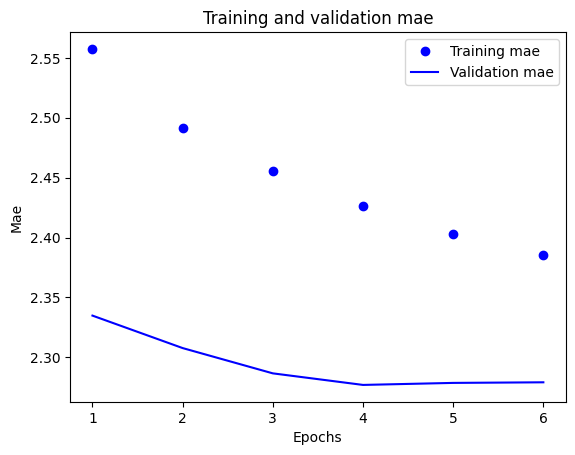

In [14]:
model = new_lstm_model(fit_residual=True)
compile_and_fit(model, 'lstm_0')

In [15]:
evaluate_model('lstm_0')

102/102 [==============================] - 9s 39ms/step - loss: 9.5319 - mae: 2.3852
Test MAE: 2.39 for model tag: lstm_0


&uarr; 2.39 was the test MAE for the stacked GRU.

**With** `fit_residual`, stacked GRU reaches the same accuracy but takes ~3x longer to train.

# Can using the date feature help any of these models?

In [16]:
temperature, raw_data, mean, std = data_to_np(use_date_features=True)
train_dataset, val_dataset, test_dataset = new_datasets()
for xb,yb in test_dataset:
    print(xb.shape, yb.shape, tf.reduce_mean(xb))
    break

(1024, 120, 19) (1024,) tf.Tensor(-0.046114465524022465, shape=(), dtype=float64)


Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 10.1961 - mae: 2.4759
Epoch 1: val_mae improved from inf to 2.23592, saving model to data/models/jena_lstm_1.keras
205/205 [==============================] - 59s 126ms/step - loss: 10.1961 - mae: 2.4759 - val_loss: 8.2786 - val_mae: 2.2359
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 9.1924 - mae: 2.3590
Epoch 2: val_mae improved from 2.23592 to 2.22139, saving model to data/models/jena_lstm_1.keras
205/205 [==============================] - 22s 105ms/step - loss: 9.1924 - mae: 2.3590 - val_loss: 8.1386 - val_mae: 2.2214
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 8.7732 - mae: 2.3069
Epoch 3: val_mae did not improve from 2.22139
205/205 [==============================] - 22s 107ms/step - loss: 8.7732 - mae: 2.3069 - val_loss: 8.1542 - val_mae: 2.2270
Epoch 4/50
205/205 [==============================] - ETA: 0s - loss: 8.4795 - mae: 2.2712
Epoch 4: val_mae did not i

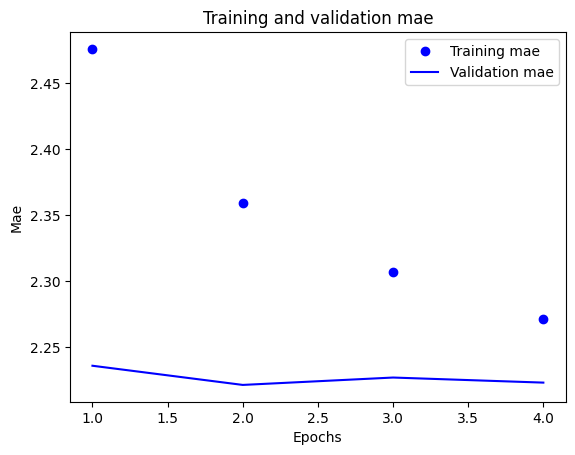

In [17]:
model = new_lstm_model(fit_residual=True)
compile_and_fit(model, 'lstm_1')

In [18]:
evaluate_model('lstm_1')

102/102 [==============================] - 9s 40ms/step - loss: 8.8562 - mae: 2.3209
Test MAE: 2.32 for model tag: lstm_1


&uarr; so we've improved the model without increasing time it takes to train (o:

&darr; let's see if this helps the dense model too

Epoch 1/50
202/205 [============================>.] - ETA: 0s - loss: 11.9398 - mae: 2.6486
Epoch 1: val_mae improved from inf to 2.54107, saving model to data/models/jena_dense_0.keras
205/205 [==============================] - 9s 43ms/step - loss: 11.9335 - mae: 2.6483 - val_loss: 10.7844 - val_mae: 2.5411
Epoch 2/50
204/205 [============================>.] - ETA: 0s - loss: 10.3150 - mae: 2.4757
Epoch 2: val_mae improved from 2.54107 to 2.40010, saving model to data/models/jena_dense_0.keras
205/205 [==============================] - 9s 43ms/step - loss: 10.3151 - mae: 2.4758 - val_loss: 9.7596 - val_mae: 2.4001
Epoch 3/50
204/205 [============================>.] - ETA: 0s - loss: 9.9141 - mae: 2.4282
Epoch 3: val_mae improved from 2.40010 to 2.23840, saving model to data/models/jena_dense_0.keras
205/205 [==============================] - 9s 43ms/step - loss: 9.9137 - mae: 2.4280 - val_loss: 8.5210 - val_mae: 2.2384
Epoch 4/50
203/205 [============================>.] - ETA: 0s - lo

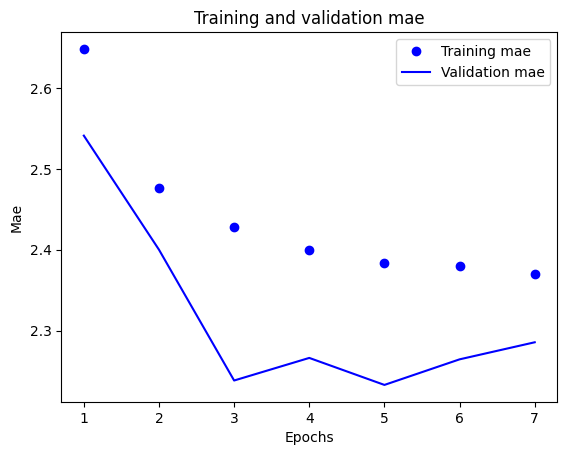

In [19]:
model = new_model(temporal_weight_range=[0.0, 2.0], l2_factor=1e-2, dropout_rate=0.5, fit_residual=True)
compile_and_fit(model, 'dense_0')

In [20]:
evaluate_model('dense_0')

102/102 [==============================] - 3s 28ms/step - loss: 9.7333 - mae: 2.4136
Test MAE: 2.41 for model tag: dense_0
